**Alice, Ethan, Cole**

Spring 2020

CS 443: Computational Neuroscience

Project 4: Motion estimation

In [176]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from motion import MotionNet,KernelParams, LayerParams, HGateParams
from random_dot_stimulus import make_random_dot_stimulus
from net_plots import vector_sum_plot


plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 4) Build the deep network layers (Layers 3-6)

### 4a. Layer 3: Short-range filter cells

#### (i) Implement helper methods

Layers 3+ do convolution to compute their `netIn`, so you will create a method that handles the construction of all the various kernels.

- Implement `make_kernels` in `MotionNet`. This makes all the excitatory/inhibitory convolutional kernels in Levels 3+. For now, just create the Level 3 excitatory anisotropic Gaussian kernels. The elongated direction should align with the preferred direction of each neuron. I suggest a filter size of (13, 13) or thereabouts (small relative to the spatial extent of the video). Remember to wrap code in level-specific boolean.
- Call `make_kernels` in constructor to build all the kernels whenever you create a network.

#### (ii) Implement and plot the layer output

Here are the steps we will perform over and over again to add a new layer.

- Implement `d_short_range_filter`.
- Update `update_net` to integrate cell activity in Level 3 (remember to put your code in a boolean if statement).
- Simulate the noise-free rightward motion RDK video (`test_rdk_0`) with network layers 1, 2, and 3.
- Run the direction decode test below.
- In the cell below, compute the rectifed layer output of the short-range filter (srf) cells.
- Plot the activation of the rectified output of all directions using `plot_act_image_grid`. Compare for consistency to `right_test_level3_grid.mov`. 
    - Note that I am plotting starting at time step 9 to the end in steps of 10.
- Plot the rectified srf cells using your vector sum plot. Compare for consistency with `right_test_level3_vectors.mov`

In [25]:
# Set up input
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
# lvl3_params = LayerParams(tau=1, excit_g=10, inhib_g=40, output_thres=0.002)
# lvl3_ker_params = KernelParams(sigma=3, sz=(13,13), gain=1)
lvl3_params = LayerParams(tau=0.5, output_thres=0.002) # output_thres=0.3
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                do_lvl4=False,
                do_lvl5=False,
                do_lvl6=False)
net.simulate(right_motion)
# Compute layer 3 output activation
srf_out = net.srf_out
# print(srf_cells.shape)

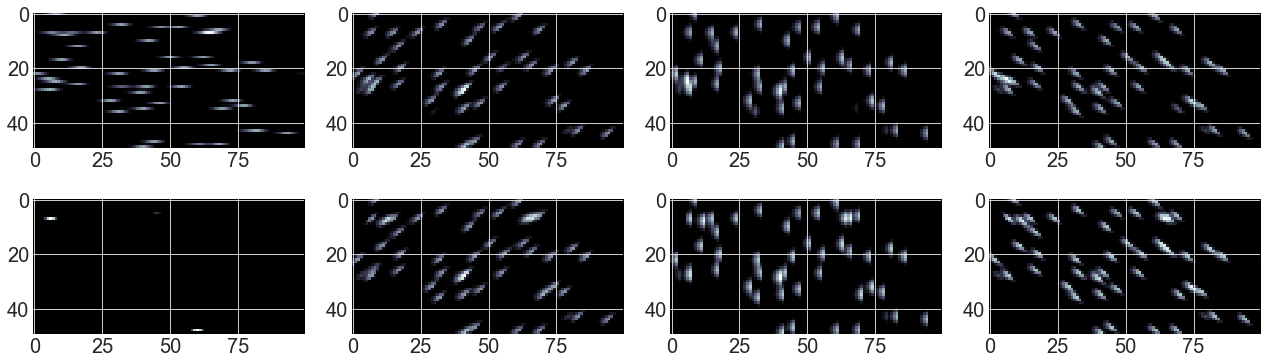

In [28]:
# Your grid of image plots of the layer 3 cells output over time
from net_plots import plot_act_image_grid
plot_act_image_grid(srf_out[::5], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))

#### Test: Decoded directional transient directions

**IMPORTANT NOTE:** Your exact values **WILL** differ and thats ok (due to parameter choices and different implementation decisions). You simply want to get rough qualitative agreement.

In [29]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.srf_cells, -1)}\nand should roughly look like\n[112.433 106.568 102.521 102.601   0.5   105.73  105.342 107.313]')

Your decoded evidence for each direction at the end of the simulation is
[4.891 4.373 4.499 4.537 0.084 4.676 4.668 4.61 ]
and should roughly look like
[112.433 106.568 102.521 102.601   0.5   105.73  105.342 107.313]


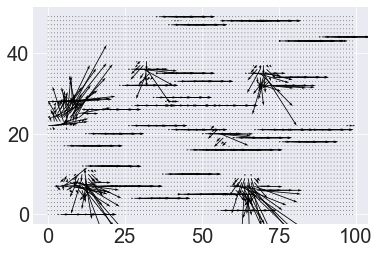

In [30]:
# Your vector sum plot of the layer 3 output over time
vector_sum_plot(net.srf_out, figSz=(18, 9), pause=0.01)

### 4b. Layer 4: Spatial and directional competition cells in MT

Adding layer 4 follows the same procedure as before to add a new layer:

- Update `make_kernels` to build Level 4 excitatory and inhibitory kernels. Kernel sizes should be between 1.5-2x those used in Layer 3, though remember we want to implement on-center/off-surround organization (excit filter ~same size as Layer 3, inhib filter a bit bigger with larger sigma).
- Implement `d_competition_layer`.
- Update `update_net` to integrate cell activity in Level 4 (remember to put your code in a boolean if statement).
- Simulate the noise-free rightward motion RDK video (`test_rdk_0`) with network layers 1, 2, 3, and 4.
- Run the direction decode test below.
- In the cell below, compute the rectifed competition cell output.
- Plot the activation of the rectified output of all directions using `plot_act_image_grid`. Compare for consistency to `right_test_level4_grid.mov`.
    - Note that I am plotting starting at time step 9 to the end in steps of 10. (*Please ignore the drifting of the placement of the second row of plots*).
- Plot the rectified competition cells using your vector sum plot. Compare for consistency with `right_test_level4_vectors.mov`

In [48]:
# Define meta parameters
# ?
# Set up input
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)

# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                do_lvl5=False,
                do_lvl6=False)
net.simulate(right_motion)

# Compute layer 4 output activation
comp_out = net.comp_out

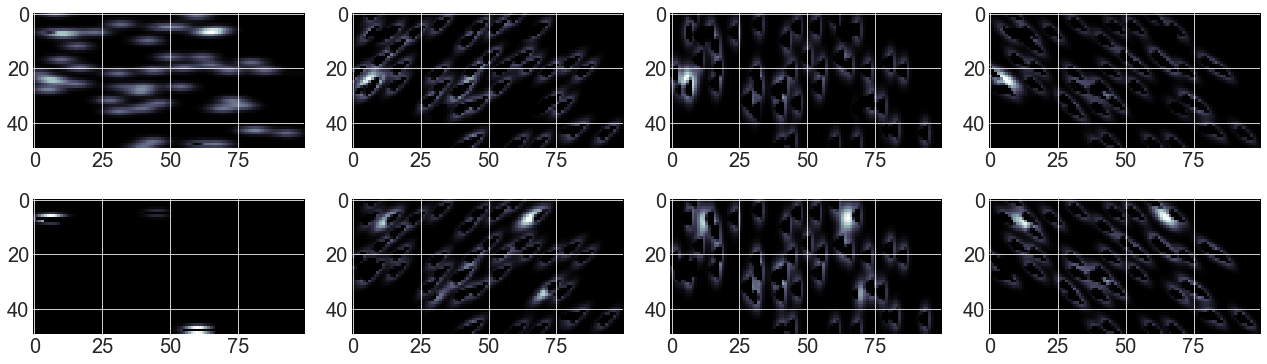

In [49]:
# Your grid of image plots of the layer 4 cells output over time
plot_act_image_grid(comp_out[::5], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))

#### Test: Decoded directional transient directions

**IMPORTANT NOTE:** Your exact values **WILL** differ and thats ok (due to parameter choices and different implementation decisions). You simply want to get rough qualitative agreement.

In [50]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.comp_cells, -1)}\nand should roughly look like\n[118.35   47.927  34.174  42.399   0.     48.013  38.499  46.949]')

Your decoded evidence for each direction at the end of the simulation is
[1.466 0.454 0.433 0.492 0.003 0.562 0.484 0.524]
and should roughly look like
[118.35   47.927  34.174  42.399   0.     48.013  38.499  46.949]


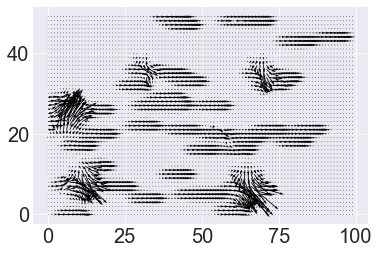

In [51]:
# Your vector sum plot of the layer 4 output over time
vector_sum_plot(net.comp_out, figSz=(18, 9), pause=0.01)

### 4e. Level 5: Long-range filter in MT

Adding layer 5 follows the same procedure as before to add a new layer:

- Update `make_kernels` to build Level 5 excitatory kernels. Filter size should be ~4x Layer 3 SRF (hence the name :)
- Implement `d_long_range`.
- Update `update_net` to integrate cell activity in Level 5 (remember to put your code in a boolean if statement).
- Simulate the noise-free rightward motion RDK video (`test_rdk_0`) with network layers 1, 2, 3, 4, and 5.
- Run the direction decode test below.
- In the cell below, rectify the output of the long-range filter cells.
- Plot the activation of the rectified output of all directions using `plot_act_image_grid`. Compare for consistency to `right_test_level5_grid.mov`.
    - Note that I am plotting starting at time step 9 to the end in steps of 10. (*Please ignore the drifting of the placement of the second row of plots*).
- Plot the rectified long-range filter cells using your vector sum plot. Compare for consistency with `right_test_level5_vectors.mov`

In [48]:
# Define meta parameters

np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)
lvl5_params = LayerParams(tau=.5)
lvl5_excit_ker_params = KernelParams(sigma=(2,0.5), sz=(52,52), gain=25)

# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                lvl5_params = lvl5_params,
                lvl5_excit_ker_params = lvl5_excit_ker_params,
                do_lvl6=False)
net.simulate(right_motion)

# Compute layer 5 output activation
lr_out = net.lr_out

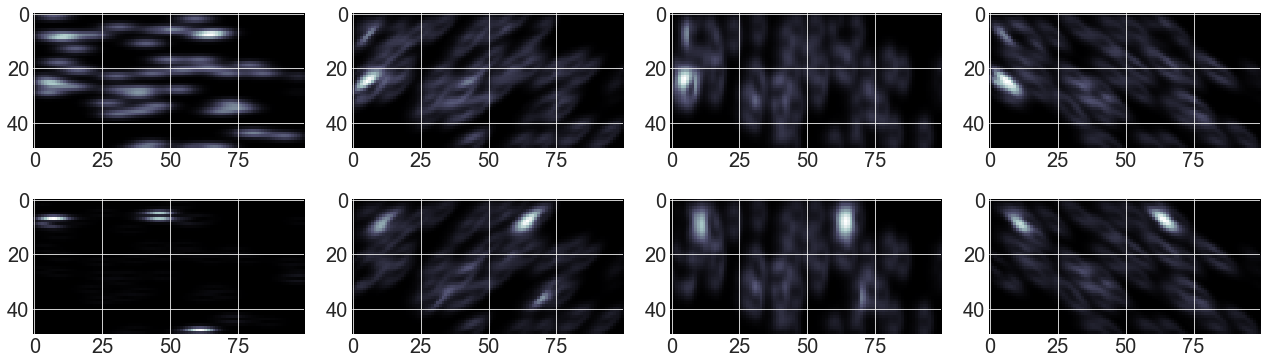

In [49]:
# Your grid of image plots of the layer 5 cells output over time
plot_act_image_grid(lr_out[::5], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))

#### Test: Decoded directional transient directions

**IMPORTANT NOTE:** Your exact values **WILL** differ and thats ok (due to parameter choices and different implementation decisions). You simply want to get rough qualitative agreement.

In [50]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.lr_cells, -1)}\nand should roughly look like\n[212.698  91.528  67.421  80.858   0.     90.174  73.545  89.044]')

Your decoded evidence for each direction at the end of the simulation is
[1.569 0.499 0.471 0.532 0.007 0.589 0.513 0.554]
and should roughly look like
[212.698  91.528  67.421  80.858   0.     90.174  73.545  89.044]


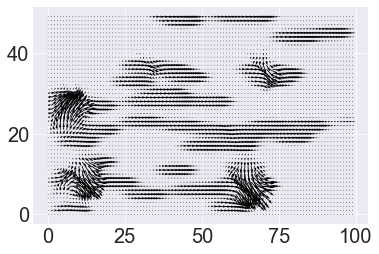

In [51]:
# Your vector sum plot of the layer 5 output over time
vector_sum_plot(lr_out, figSz=(18, 9), pause=0.01)

### 4f. Level 6: Direction grouping in MSTd

Adding layer 6 follows the same procedure as before to add a new layer, **with the exception of implementing MSTd-MT feedback (Layer 6-> 5)**

#### (i) Implement and test MSTd-MT feedback (Layer 6 -> Layer 5)

- `make_mstd_fb_wts`. Weights for directional inhibition in MSTd and feedback from MSTd to MT (long-range filters). Each cell recieves no inhibition from other neurons with the same direction preference (0 wt). Each cell recieves the most inhibition from the opponent direction (2 wt). All other directions recieve equally weighted moderate inhibition (1 wt). **Run the test code below**.
- Create your MSTd feedback weights in the constructor.
- Implement `mstd_fb` **then run the test code below**.

#### (ii) Test `make_mstd_fb_wts`

In [148]:
dt = 0.1
n_dirs = 8

test_net = MotionNet(dt,
                     n_dirs,
                     lvl1_params=None,
                     lv1_hgate_params=None,
                     do_lvl2=False,
                     do_lvl3=False,
                     do_lvl4=False,
                     do_lvl5=False,
                     do_lvl6=False)
wts = test_net.make_mstd_fb_wts()
print('Your MSTd inhibitory weight matrix is:\n', wts)

Your MSTd inhibitory weight matrix is:
 [[0. 1. 1. 1. 2. 1. 1. 1.]
 [1. 0. 1. 1. 1. 2. 1. 1.]
 [1. 1. 0. 1. 1. 1. 2. 1.]
 [1. 1. 1. 0. 1. 1. 1. 2.]
 [2. 1. 1. 1. 0. 1. 1. 1.]
 [1. 2. 1. 1. 1. 0. 1. 1.]
 [1. 1. 2. 1. 1. 1. 0. 1.]
 [1. 1. 1. 2. 1. 1. 1. 0.]]


It should be:

    [[0. 1. 1. 1. 2. 1. 1. 1.]
     [1. 0. 1. 1. 1. 2. 1. 1.]
     [1. 1. 0. 1. 1. 1. 2. 1.]
     [1. 1. 1. 0. 1. 1. 1. 2.]
     [2. 1. 1. 1. 0. 1. 1. 1.]
     [1. 2. 1. 1. 1. 0. 1. 1.]
     [1. 1. 2. 1. 1. 1. 0. 1.]
     [1. 1. 1. 2. 1. 1. 1. 0.]]

#### (iii) Test `mstd_fb`

In [151]:
dt = 0.1
n_dirs = 8
n_frames = 1
np.random.seed(0)

net = MotionNet(dt=dt,
                n_dirs=n_dirs,
                lvl1_params=None,
                lv1_hgate_params=None,
                lvl2_inter_params=None,
                lvl2_params=None,
                lvl3_params=None,
                lvl3_excit_ker_params=None,
                lvl4_params=None,
                lvl4_excit_ker_params=None,
                lvl4_inhib_ker_params=None,
                lvl5_params=None,
                lvl5_excit_ker_params=None,
                lvl6_params=None,
                lvl6_inhib_ker_params=None,
                do_lvl2=False,
                do_lvl3=False,
                do_lvl4=False,
                do_lvl5=False,
                do_lvl6=False
                )
net.mstd_inhib_ker = np.array([[0, 1, 0], [1, 2, 1], [0, 1, 0]])

test_act = np.random.random(size=(8, 4, 4))
test_fb = net.mstd_fb(t=1, curr_mstd_out=test_act)
print('Your feedback signal from MSTd (1st 2 directions) is:\n', test_fb[:2])

(8, 4, 4)
(3, 3)
Your feedback signal from MSTd (1st 2 directions) is:
 [[[36.893 39.322 46.138 52.622]
  [39.699 36.893 39.322 46.138]
  [46.182 39.699 36.893 39.322]
  [52.998 46.182 39.699 36.893]]

 [[34.851 37.871 43.644 50.782]
  [42.356 34.851 37.871 43.644]
  [49.494 42.356 34.851 37.871]
  [55.267 49.494 42.356 34.851]]]


You should get the following output:

    Your feedback signal from MSTd (1st 2 directions) is:
     [[[12.499 17.705 19.242 15.673]
      [17.464 21.184 22.453 19.604]
      [21.062 22.546 23.542 20.478]
      [18.182 19.925 21.551 18.902]]

     [[12.181 19.097 20.065 15.029]
      [17.794 25.019 24.393 18.994]
      [21.355 24.216 24.465 18.923]
      [16.833 18.432 18.755 16.604]]]

#### (iv) Implement Layer 6 (MSTd)

This now follows the usual workflow:

- Update `make_kernels` to build Level 6 inhibitory feedback kernel. Filter size should be same size as the long-range filter.
- Update `d_long_range` to include this feedback signal if we are simulating Layer 6. **NOTE:** When computing the MSTd feedback signal, it should be based on the output signal at $t-1$. Why? `self.mstd_out[t]` should be undefined (we compute Level 5 before Level 6).
- Implement `d_mstd_grouping` (Level 6 derivatives).
- Update `update_net` to integrate cell activity in Level 6 (remember to put your code in a boolean if statement).
- Simulate the noise-free rightward motion RDK video (`test_rdk_0`) with all network layers.
- Run the direction decode test below.
- In the cell below, rectify the MSTd cells.
- Plot the activation of the rectified output of all directions using `plot_act_image_grid`. Compare for consistency to `right_test_level6_grid.mov`. Note that I am plotting starting at time step 9 to the end in steps of 10. (*Please ignore the drifting of the placement of the second row of plots*).
- Plot the rectified MSTd cells using your vector sum plot. Compare for consistency with `right_test_level6_vectors.mov`

In [172]:
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)
lvl5_params = LayerParams(tau=.5)
lvl5_excit_ker_params = KernelParams(sigma=(2,0.5), sz=(52,52), gain=25)
lvl6_params = LayerParams(tau=5)
lvl6_inhib_ker_params= KernelParams(sigma=4, sz=(52,52), gain = 5)


# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                lvl5_params = lvl5_params,
                lvl5_excit_ker_params = lvl5_excit_ker_params,
                lvl6_params = lvl6_params,
                lvl6_inhib_ker_params = lvl6_inhib_ker_params)
net.simulate(right_motion)
# Compute rectified layer output
mstd_out = net.mstd_out

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100)
(8, 52, 52)
Current MSTD Out
(50, 100

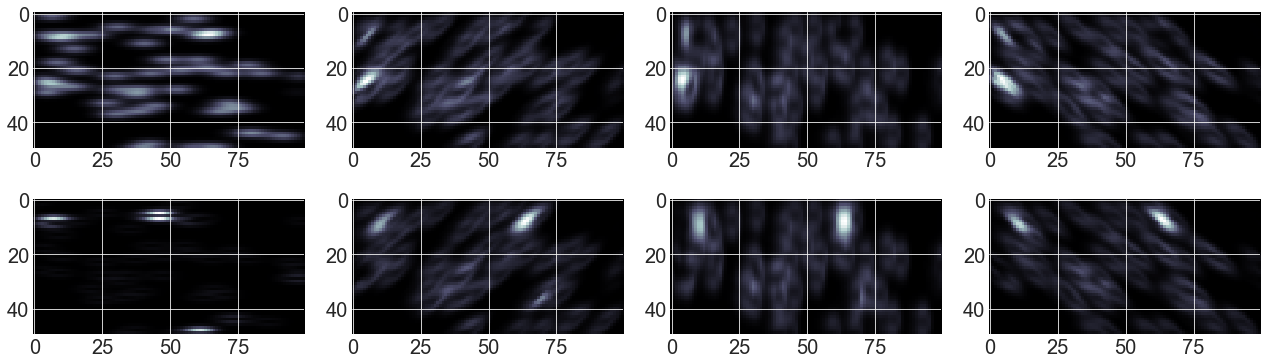

In [173]:
# Your grid of image plots of the layer 6 cells output over time
plot_act_image_grid(mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))

#### Test: Decoded directional transient directions

**IMPORTANT NOTE:** Your exact values **WILL** differ and thats ok (due to parameter choices and different implementation decisions). You simply want to get rough qualitative agreement.

In [174]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}\nand should roughly look like\n[402.962   0.149   0.      0.047   0.      0.453   0.17    0.027]')

Your decoded evidence for each direction at the end of the simulation is
[1.488 0.491 0.464 0.523 0.007 0.576 0.503 0.543]
and should roughly look like
[402.962   0.149   0.      0.047   0.      0.453   0.17    0.027]


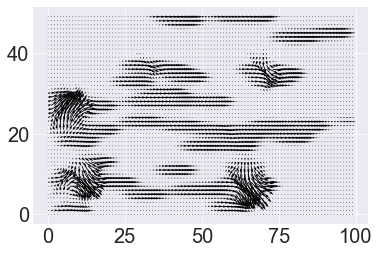

In [171]:
# Your vector sum plot of the layer 6 output over time
vector_sum_plot(mstd_out[::10], figSz=(18, 9), pause=0.01)

## Task 5) Direction discrimination with noise

- Perform your own full network simulations to discriminate the coherent motion direction in videos with random noise (uncorrelated frame-to-frame) and correlated every 3 frames.
- Show dominant direct decoded direction and make plots of each network stage.

### 5a. Simulations with uncorrelated frame-to-frame noise.

Generate new random dot kinematograms with noise (that you already implemented support for). Test out the full network with noise, visualize the estimated motion, and print out the decoded evidence for different motion directions.

In [175]:
np.random.seed(0)
right_motion10 = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1), noise_prop=.1)

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)
lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)
lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)
lvl5_params = LayerParams(tau=.5)
lvl5_excit_ker_params = KernelParams(sigma=(2,0.5), sz=(52,52), gain=25)
lvl6_params = LayerParams(tau=5)
lvl6_inhib_ker_params= KernelParams(sigma=4, sz=(52,52), gain = 5)


# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                lvl5_params = lvl5_params,
                lvl5_excit_ker_params = lvl5_excit_ker_params,
                lvl6_params = lvl6_params,
                lvl6_inhib_ker_params = lvl6_inhib_ker_params)
net.simulate(right_motion10)

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)})

Your decoded evidence for each direction at the end of the simulation is
[1.538 0.53  0.512 0.555 0.056 0.618 0.553 0.581]
and should roughly look like
[402.962   0.149   0.      0.047   0.      0.453   0.17    0.027]


### 5b. Simulations with complex noise: coherence videos.

- Import the 10 videos with different levels of coherence (in `coherence_stimuli.mat`, which is in MATLAB format. Check out `loadmat` function). In these videos, three coherent motion videos are interleaved (e.g. frame 1, 4, 7, ... go together, 2, 5, 8, ... go together, etc.). The interleaving makes it challenging for the network to detect the percieved motion because dots don't correspond to each other frame-to-frame, yet we still percieve motion!
- There are 10 levels of dot coherence (100% coherence = no noise, 0% coherence = all noise). Test out the network like in 5a in SOME of these videos (doesn't need to be all).

In [ ]:
vids = sio.loadmat('data/coherence_stimuli.mat')
net.simulate(vids['stimulus_010_coh'])

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 1 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 1 0 0]
  ...
  [1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 1 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [ ]:
net.simulate(vids['stimulus_030_coh'])

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

In [ ]:
net.simulate(vids['stimulus_060_coh'])

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

In [ ]:
net.simulate(vids['stimulus_080_coh'])

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

In [ ]:
net.simulate(vids['stimulus_100_coh'])

plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

## Extensions

### 1. Additional visualizations

Neural network simulations with many areas and dimensions (space, motion direction, etc) present challenges to interpreting and visualizing the dynamics. Extensions like the following ideas are aimed to give us a better picture of the network's operation.

#### Needle plot

- Visualize the activity of ALL direction cells at ALL spatial positions with a needle plot. For each position (x, y), draw line segments (no arrowheads) coming out of (x,y) aligned each of the 8 preferred directions (e.g. for rightward motion, line sticks to the right, for up-and-right motion line sticks +45 deg, etc). The length is proportioonal to the cell activity. Do whatever normalization to make things look good/helpful. Make your plot show activations over time.

#### Mean activity plots

- Plot the mean direction activity across space for each area.

#### Better vector sum plots

- Superimpose the motion vectors onto of the input dot patterns so that you can see the correspondance.

### 2. Additional analyses

Analyze the network in new ways. Many ways to do this, here are some ideas:

- Plot/interpret the motion direction evidence over time in different areas.
- Compute the relative SNR (signal to noise ratio) in different areas for the dominant motion vs rest.

### 3. Additional RDKs

- Analyze/simulate your network with RDKs with different movement directions, changing directions, two simultaneous directions (called transparent motion), etc...lots of possibilities.

### 4. Different motion detection mechanisms

- We used nulling inhibition to detect motion. You should be able to "swap in" other motion detection mechanisms (for example, in easiest-to-hardest to implement order, Reichardt, Gradient, Spatio-temporal energy, etc).
- For Reichardt (correlation-based), the easiest approach that tends to work well is to add the pre and post movement activations together in whatever the neuron's prefered direction is, then apply a threshold to filter out low matches. For example, to detect rightward motion, you could do something like $x_i(t-1) + x_{i+1}(t)$ then compare that to an activation threshold.

### 5. Support for multiple speeds

- (Challenging) This is more open ended. A simplification we made to keep the project scope reasonable is to only support cells that only detect 1 px/frame motion. Experiment, brainstorm, and implement support for other speeds (2 px/frame, 3 px/frame, etc).